# ABC calibration of $I_\text{Na}$ in standardised model to unified dataset.

In [2]:
import os, tempfile
import logging
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [3]:
from ionchannelABC import theoretical_population_size
from ionchannelABC import IonChannelDistance, EfficientMultivariateNormalTransition, IonChannelAcceptor
from ionchannelABC.experiment import setup
from ionchannelABC.visualization import plot_sim_results, plot_kde_matrix_custom
import myokit

In [4]:
from pyabc import Distribution, RV, History, ABCSMC
from pyabc.epsilon import MedianEpsilon
from pyabc.sampler import MulticoreEvalParallelSampler, SingleCoreSampler
from pyabc.populationstrategy import ConstantPopulationSize

## Initial set-up

Load experiments used for unified dataset calibration:
 - Steady-state activation [Sakakibara1992]
 - Activation time constant [Schneider1994]
 - Steady-state inactivation [Sakakibara1992]
 - Inactivation time constant (fast+slow) [Sakakibara1992]
 - Recovery time constant (fast+slow) [Sakakibara1992]

In [5]:
from experiments.ina_sakakibara import (sakakibara_act,
                                        sakakibara_inact,
                                        sakakibara_inact_kin,
                                        sakakibara_rec)
from experiments.ina_schneider import schneider_taum

In [6]:
modelfile = 'models/standardised_ina.mmt'

Combine model and experiments to produce:
 - observations dataframe
 - model function to run experiments and return traces
 - summary statistics function to accept traces

In [19]:
observations, model, summary_statistics = setup(modelfile,
                                                sakakibara_act,
                                                sakakibara_inact,
                                                schneider_taum,
                                                sakakibara_inact_kin,
                                                sakakibara_rec)

In [20]:
assert len(observations)==len(summary_statistics(model({})))

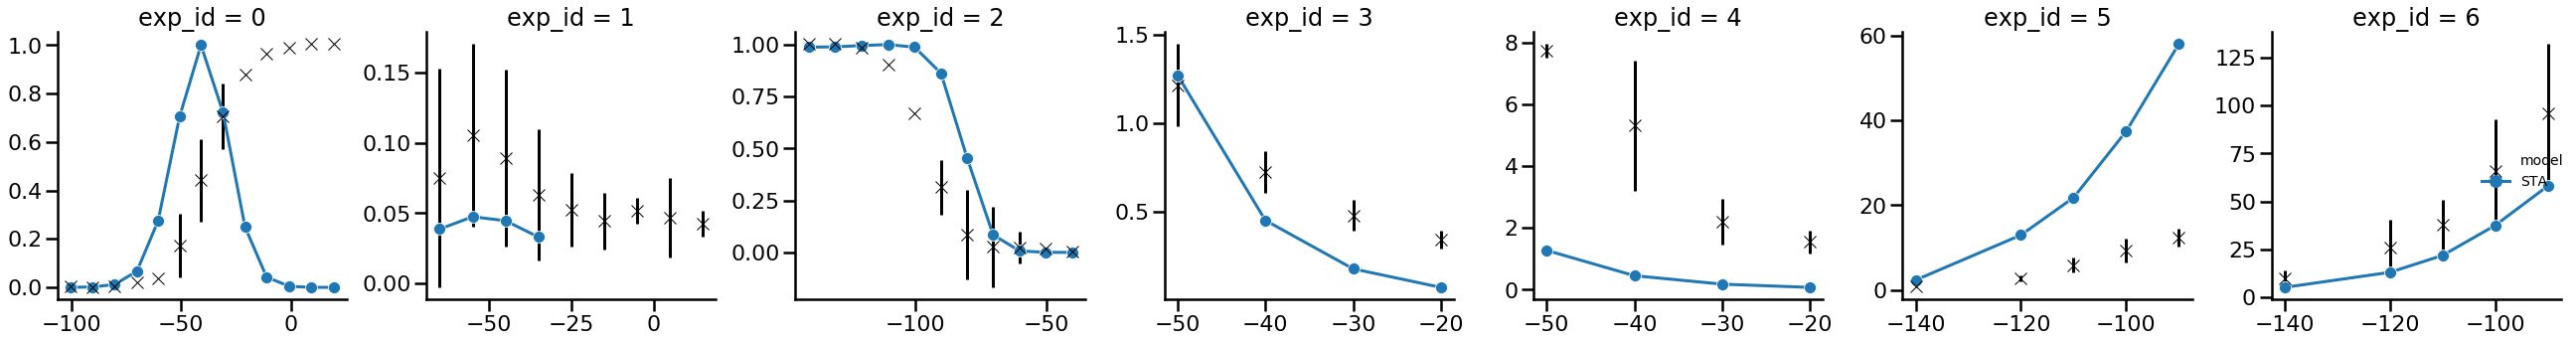

In [21]:
g = plot_sim_results(modelfile,
                     sakakibara_act,
                     schneider_taum,
                     sakakibara_inact,
                     sakakibara_inact_kin,
                     sakakibara_rec)

### Set up prior ranges for each parameter in the model.

See the modelfile for further information on specific parameters. Prepending `log_' has the effect of setting the parameter in log space.

In [22]:
limits = {'log_ina.A': (0., 1.),
          'log_ina.p_1': (1., 5.),
          'ina.p_2': (1e-7, 0.2),
          'log_ina.p_3': (-3., 1.),
          'ina.p_4': (1e-7, 0.4),
          'log_ina.p_5': (-1., 3.),
          'ina.p_6': (1e-7, 0.2),
          'log_ina.p_7': (-4., 0.),
          'ina.p_8': (1e-7, 0.2)}
prior = Distribution(**{key: RV("uniform", a, b - a)
                        for key, (a,b) in limits.items()})

In [23]:
# Test this works correctly with set-up functions
assert len(observations) == len(summary_statistics(model(prior.rvs())))

### Run ABC calibration

In [10]:
db_path = ("sqlite:///" + os.path.join(tempfile.gettempdir(), "standardised_ina_unified.db"))

In [34]:
logging.basicConfig()
abc_logger = logging.getLogger('ABC')
abc_logger.setLevel(logging.DEBUG)
eps_logger = logging.getLogger('Epsilon')
eps_logger.setLevel(logging.DEBUG)

In [35]:
pop_size = theoretical_population_size(2, len(limits))
print("Theoretical minimum population size is {} particles".format(pop_size))

Theoretical minimum population size is 1024 particles


In [36]:
abc = ABCSMC(models=model,
             parameter_priors=prior,
             distance_function=IonChannelDistance(
                 exp_id=list(observations.exp_id),
                 variance=list(observations.variance),
                 delta=0.05),
             population_size=ConstantPopulationSize(1000),
             summary_statistics=summary_statistics,
             transitions=EfficientMultivariateNormalTransition(),
             eps=MedianEpsilon(initial_epsilon=100),
             sampler=MulticoreEvalParallelSampler(n_procs=8),
             acceptor=IonChannelAcceptor())

DEBUG:ABC:ion channel weights: {'0': 0.8994387935145443, '1': 0.8994387935145443, '2': 0.8994387935145443, '3': 0.8994387935145443, '4': 0.8994387935145443, '5': 0.34109494248661376, '6': 0.26537052793588445, '7': 0.32983672328438474, '8': 0.8994387935145443, '9': 0.8994387935145443, '10': 0.8994387935145443, '11': 0.8994387935145443, '12': 0.8994387935145443, '13': 1.0629731196080978, '14': 1.0629731196080978, '15': 1.0629731196080978, '16': 1.0629731196080978, '17': 1.0629731196080978, '18': 0.3987161257732702, '19': 0.2477787758193123, '20': 0.2744406241533312, '21': 0.6846716015655817, '22': 1.0629731196080978, '23': 1.0629731196080978, '24': 0.0880069631533838, '25': 0.10509399703633843, '26': 0.10859636247862713, '27': 0.14734381678808003, '28': 0.25947738164809303, '29': 0.34294789694461314, '30': 0.7616679717811788, '31': 0.24033947932778965, '32': 0.7240511521166183, '33': 1.3391800411562642, '34': 1.5036407479649283, '35': 1.8235643113617217, '36': 1.8235643113617217, '37': 2

In [37]:
obs = observations.to_dict()['y']
obs = {str(k): v for k, v in obs.items()}

In [38]:
abc_id = abc.new(db_path, obs)

INFO:History:Start <ABCSMC(id=7, start_time=2019-10-07 09:20:07.543703, end_time=None)>


In [ ]:
history = abc.run(minimum_epsilon=0., max_nr_populations=100, min_acceptance_rate=0.01)

INFO:ABC:t:0 eps:100
DEBUG:ABC:now submitting population 0


In [ ]:
history = abc.run(minimum_epsilon=0., max_nr_populations=100, min_acceptance_rate=0.01)

### Results analysis

In [27]:
history = History('sqlite:///results/standardised/ina/standardised_ina_unified.db')

In [29]:
history.all_runs() # most recent is relevant

[<ABCSMC(id=1, start_time=2019-10-07 09:22:41.822951, end_time=2019-10-07 10:25:01.385888)>,
 <ABCSMC(id=2, start_time=2019-10-07 13:23:04.467718, end_time=None)>,
 <ABCSMC(id=3, start_time=2019-10-07 13:26:44.261560, end_time=None)>,
 <ABCSMC(id=4, start_time=2019-10-07 13:29:50.188286, end_time=2019-10-07 13:31:44.615235)>,
 <ABCSMC(id=5, start_time=2019-10-07 13:36:03.474546, end_time=2019-10-07 14:09:38.006716)>,
 <ABCSMC(id=6, start_time=2019-10-07 14:51:48.318988, end_time=2019-10-08 02:15:24.096680)>]

In [30]:
df, w = history.get_distribution( m=0)

In [31]:
df.describe()

name,ina.p_2,ina.p_4,ina.p_6,ina.p_8,log_ina.A,log_ina.p_1,log_ina.p_3,log_ina.p_5,log_ina.p_7
count,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000
mean,0.125904,0.024003,0.043949,0.040960,0.622762,3.739406,0.455238,0.783075,-2.291535
std,0.011136,0.013950,0.000921,0.001221,0.007629,0.169608,0.283631,0.017745,0.059694
min,0.093704,0.000084,0.041236,0.036398,0.603227,3.123394,-0.587432,0.737219,-2.479248
25%,0.118748,0.012741,0.043336,0.040197,0.617145,3.632703,0.264587,0.770606,-2.325019
50%,0.125479,0.022375,0.043948,0.040959,0.622850,3.732566,0.501416,0.781918,-2.293454
75%,0.133555,0.032850,0.044479,0.041664,0.627843,3.852662,0.663073,0.794611,-2.252672
max,0.158926,0.076428,0.047541,0.044690,0.643155,4.207898,0.994241,0.855805,-2.073635


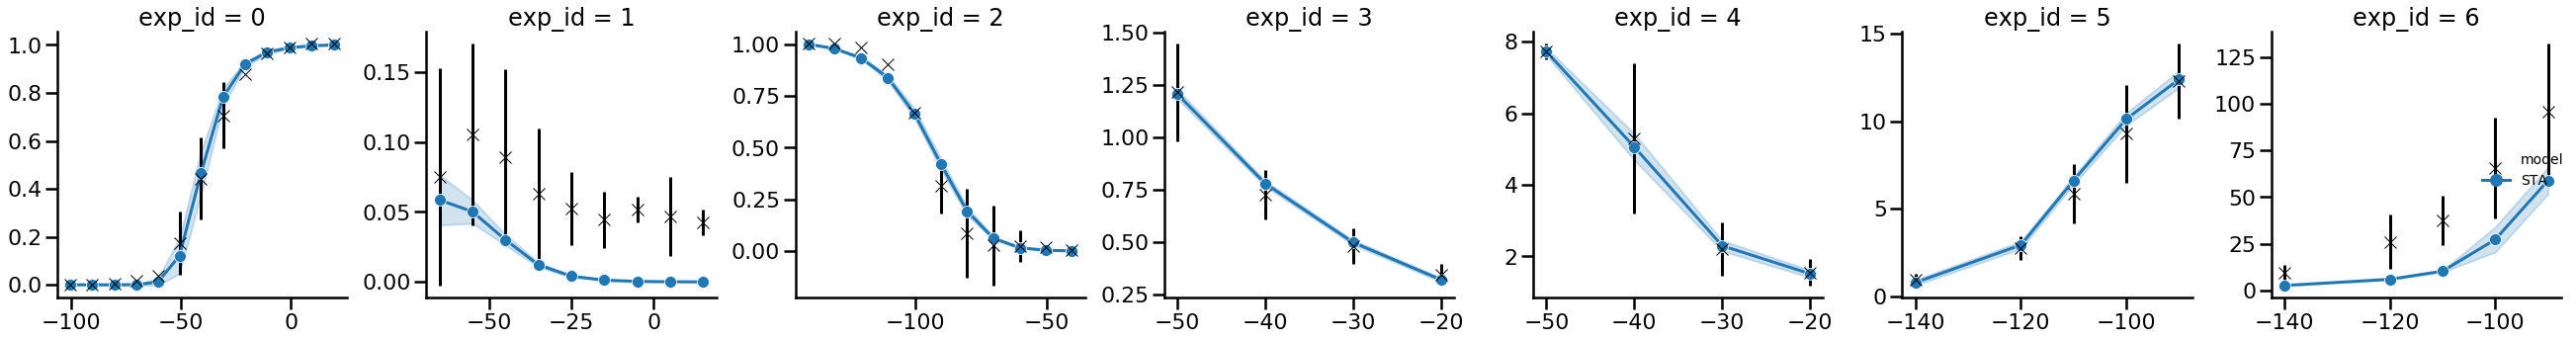

In [32]:
sns.set_context('poster')

mpl.rcParams['font.size'] = 14
mpl.rcParams['legend.fontsize'] = 14

g = plot_sim_results(modelfile,
                     sakakibara_act,
                     schneider_taum,
                     sakakibara_inact,
                     sakakibara_inact_kin,
                     sakakibara_rec,
                     df=df, w=w)

plt.tight_layout()

In [33]:
m,_,_ = myokit.load(modelfile)

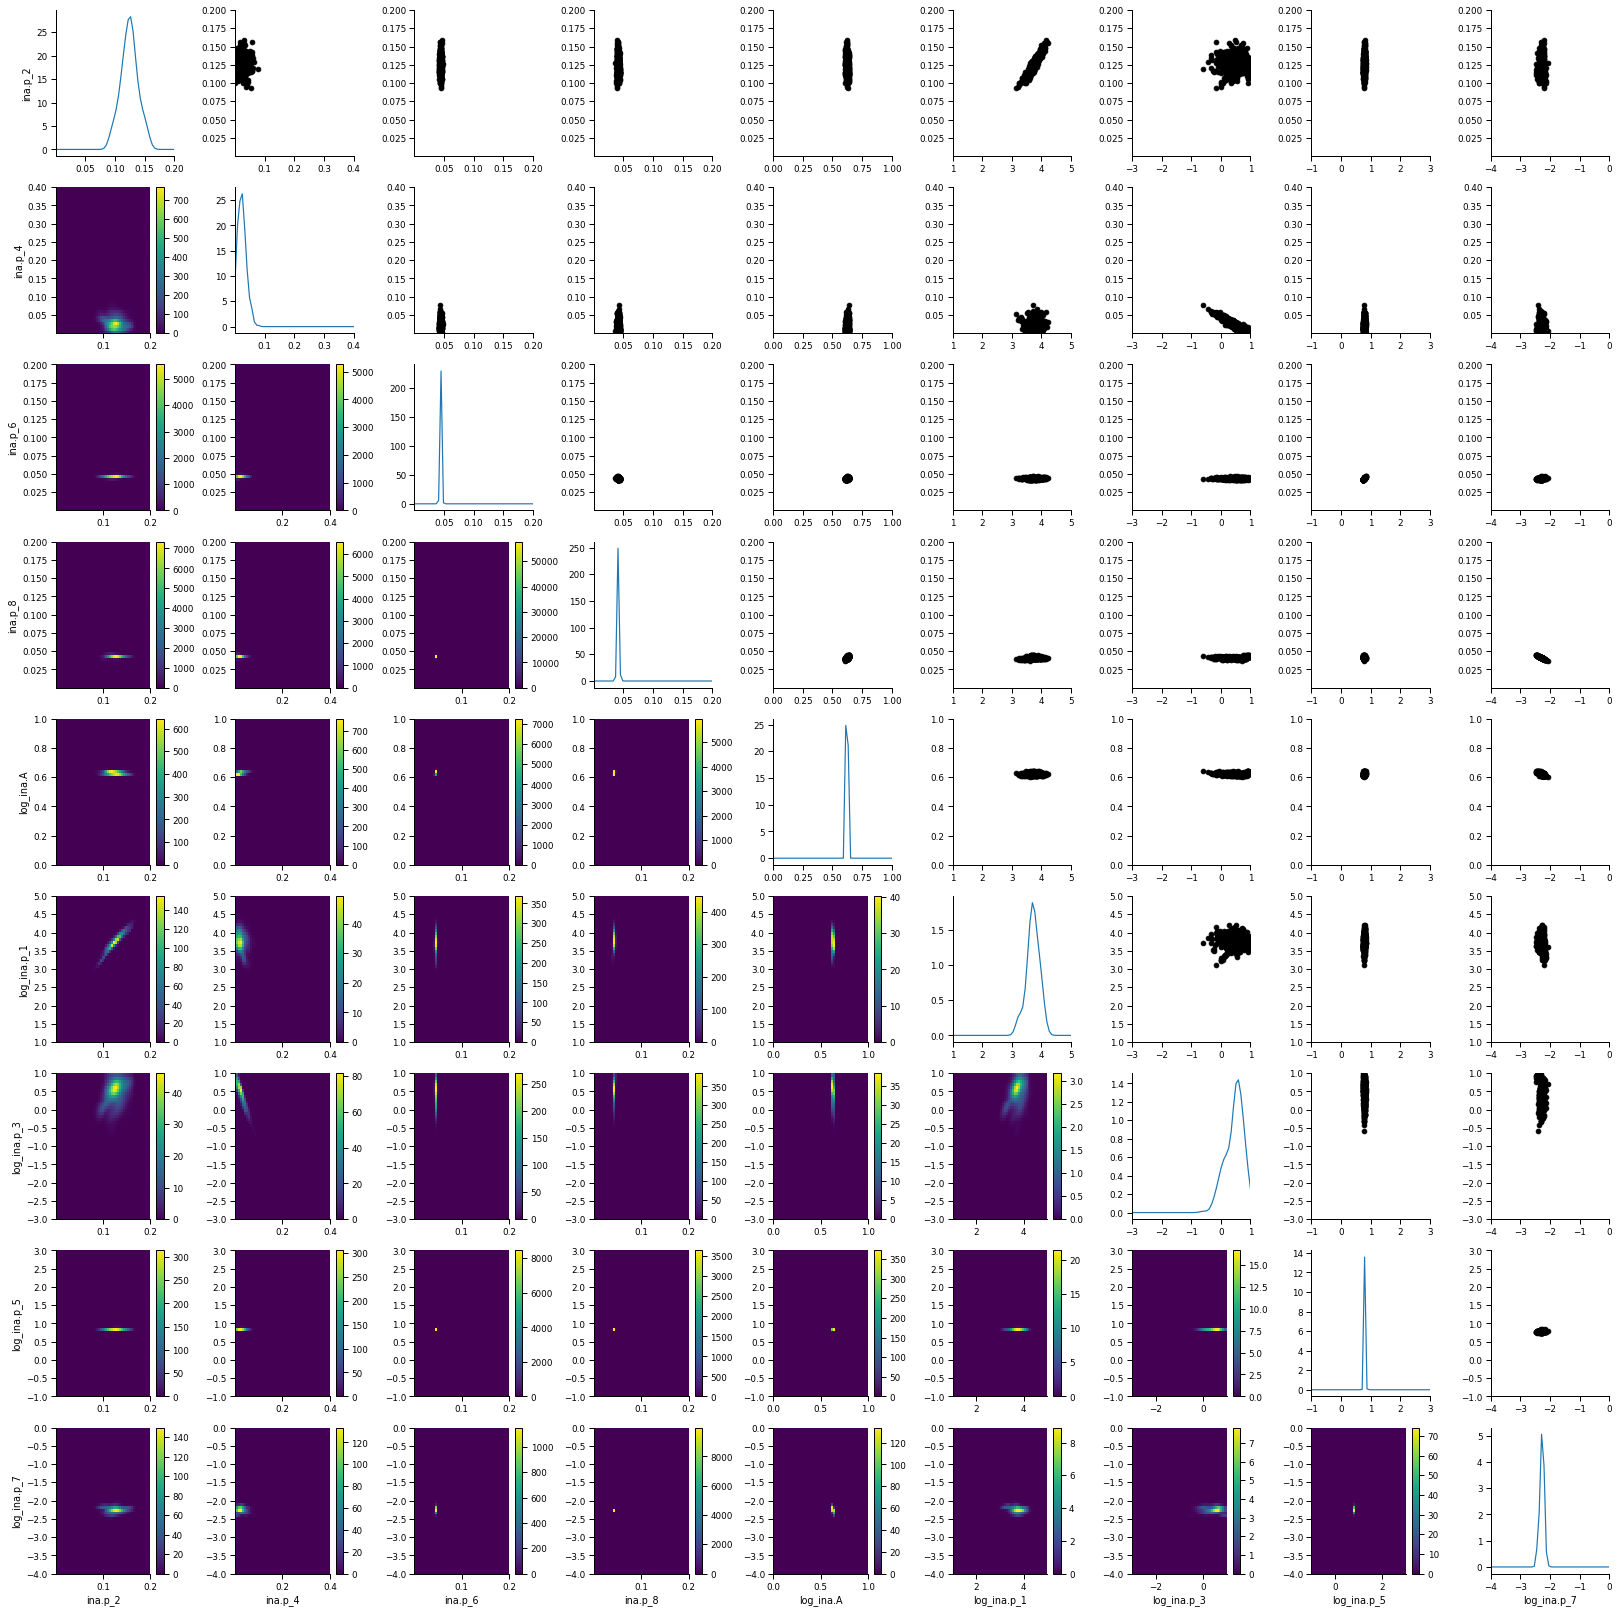

In [36]:
sns.set_context('paper')
g = plot_kde_matrix_custom(df, w, limits=limits)
plt.tight_layout()